In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from jax.flatten_util import ravel_pytree
from functools import partial
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.lagrangian as lgr
import piml_library.hamiltonian as ham
import piml_library.util as util
import piml_library.dataset_generator as dg
import piml_library.plotting as plotting
from piml_library.bnn import (
    BaselineNN, 
    compute_loss, 
    train_step, 
    create_trajectory,
)

In [2]:
@jax.jit
#L((t, q, v))
def L_analytical(state):
    q = lgr.coordinate(state)
    v = lgr.velocity(state)
    q_flat, _ = ravel_pytree(q)
    v_flat, _ = ravel_pytree(v)
    
    T = 0.5 * jnp.sum(v_flat**2)
    V = 0.5 * jnp.sum(q_flat**2)
    return T - V

In [3]:
@jax.jit
#H((t, q, p))
def H_analytical(state, m=1.0, k=1.0):
    q = ham.coordinate(state) 
    p = ham.momentum(state) 
    
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [4]:
q_dim = 1
hidden_dim = 200
learning_rate = 1e-3
num_epochs = 5000
key = jax.random.PRNGKey(0)

'''
HNNpaperでは25軌道、30点
'''
num_trajectories = 50
N_points_per_traj = 500
t_end = 25.0
t_eval = jnp.linspace(0.0, t_end, N_points_per_traj)

split_ratio = 0.5
N_points_train = int(N_points_per_traj * split_ratio)

--- 学習用・テスト用データセットの生成開始 ---
Generating 50 trajectories...
--- データセット生成完了 ---
Total Train Points: 12500
Total Test Points:  12500


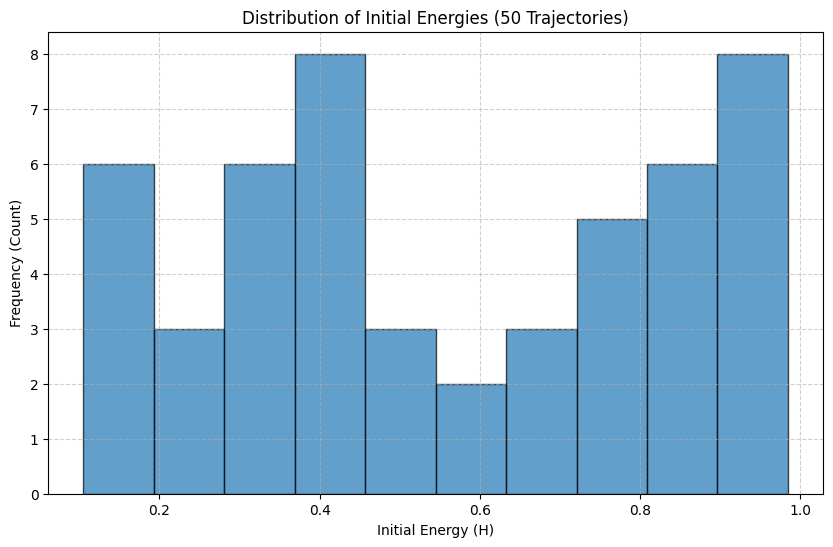

In [5]:
data_dict = dg.create_trajectory_datasets(
    L_analytical, 
    H_analytical,
    key,
    q_dim=q_dim,
    num_trajectories=num_trajectories,
    N_points_per_traj=N_points_per_traj,
    t_end=t_end,
    split_ratio=split_ratio
)

train_states = data_dict["train_states_lnn"]
train_t, train_q, train_v = train_states
train_targets = data_dict["train_targets_lnn"]
test_dataset_states = data_dict["test_dataset_states_lnn"]
test_dataset_true_accel = data_dict["test_dataset_true_accel_lnn"]
initial_energies = data_dict["initial_energies"]
N_train_total = data_dict["N_train_total"]

key, _ = jax.random.split(key) 

# --- エネルギー分布の可視化 ---
energies_np = np.array(initial_energies)

plt.figure(figsize=(10, 6))
plt.hist(energies_np, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Initial Energy (H)')
plt.ylabel('Frequency (Count)')
plt.title(f'Distribution of Initial Energies ({num_trajectories} Trajectories)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [6]:
'''
learning Process
'''

# --- モデルとオプティマイザの初期化 ---
bnn_model = BaselineNN(hidden_dim=hidden_dim, output_dim=q_dim)
model_apply_fn = bnn_model.apply  # jitで使用できるようにするためapplyというメソッドを変数に割り当てる。

key, init_key = jax.random.split(key) #同じkeyを与えると同じ値を毎回与える

# モデルを初期化するためのダミー入力 (t, q, v)
# q と v は q_dim に合わせる
dummy_q = jnp.zeros((q_dim,))
dummy_v = jnp.zeros((q_dim,))
dummy_state = (0.0, dummy_q, dummy_v)

params = bnn_model.init(init_key, dummy_state)['params'] #構造を決定
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params) #重みを追跡するために必要な内部メモリ状態

print("モデルとオプティマイザの初期化完了。学習を開始します...")

start_train_time = time.time()

'''
全バッチ学習に変更する
'''
# ミニバッチのサイズ
batch_size = 256 

# --- 学習ループ ---
for epoch in range(num_epochs):
    
    # randomly choose trajectory 
    key, data_key = jax.random.split(key)
    indices = jax.random.choice(data_key, N_train_total, shape=(batch_size,), replace=False)
    
    # make mini batch
    t_batch = train_t[indices]
    q_batch = train_q[indices]
    v_batch = train_v[indices]
    
    batch_states = (t_batch, q_batch, v_batch)
    batch_true_accel = train_targets[indices]
    
    params, opt_state, train_loss = train_step(
        params, 
        opt_state, 
        optimizer, 
        model_apply_fn, 
        batch_states, 
        batch_true_accel
    )
    
    if epoch % 500 == 0:
        test_loss = compute_loss(
            params,
            model_apply_fn,
            test_dataset_states,
            test_dataset_true_accel
        )
        print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

print("学習完了。")

# Final Test Loss
final_test_loss = compute_loss(params, model_apply_fn, test_dataset_states, test_dataset_true_accel)
final_test_loss.block_until_ready()
end_train_time = time.time()
print(f"--- Final Test Loss: {final_test_loss:.6f} ---")
print(f"--- Total Training Time: {end_train_time - start_train_time:.2f} seconds ---")

モデルとオプティマイザの初期化完了。学習を開始します...
Epoch 0, Train Loss: 0.375965, Test Loss: 0.678817
Epoch 500, Train Loss: 0.000002, Test Loss: 0.000002
Epoch 1000, Train Loss: 0.000001, Test Loss: 0.000002
Epoch 1500, Train Loss: 0.000011, Test Loss: 0.000018
Epoch 2000, Train Loss: 0.000020, Test Loss: 0.000024
Epoch 2500, Train Loss: 0.000008, Test Loss: 0.000002
Epoch 3000, Train Loss: 0.000001, Test Loss: 0.000002
Epoch 3500, Train Loss: 0.000001, Test Loss: 0.000002
Epoch 4000, Train Loss: 0.000007, Test Loss: 0.000008
Epoch 4500, Train Loss: 0.000002, Test Loss: 0.000003
学習完了。
--- Final Test Loss: 0.000001 ---
--- Total Training Time: 45.39 seconds ---


In [10]:
'''
generate trajectory
'''

# 予測と正解データ(自動微分による計算)での比較
print("軌道を生成して、真の挙動と比較します...")
#based on BNN
solver_learned = create_trajectory(model_apply_fn, params)
ds_true = lgr.state_derivative(L_analytical)
solver_true = util.ode_solver(ds_true)

initial_state = (0.0, jnp.array([1.0]), jnp.array([0.0]))
'''
t=0~20で2000ポイントに合わせる
'''
t_eval = jnp.linspace(0.0, 300.0, 6000) 

lgr_to_ham_state_fn = ham.lagrangian_state_to_hamiltonian_state(L_analytical)
lgr_states_learned = solver_learned(initial_state, t_eval) 
lgr_states_true = solver_true(initial_state, t_eval)
ham_states_learned = jax.vmap(lgr_to_ham_state_fn)(lgr_states_learned)
ham_states_true = jax.vmap(lgr_to_ham_state_fn)(lgr_states_true)

start_inference_time = time.time()
lgr_states_learned[1].block_until_ready() 
end_inference_time = time.time()
print(f"--- Trajectory Inference Time: {end_inference_time - start_inference_time:.4f} seconds ---")

print("軌道生成が完了しました。")

軌道を生成して、真の挙動と比較します...
--- Trajectory Inference Time: 0.0001 seconds ---
軌道生成が完了しました。


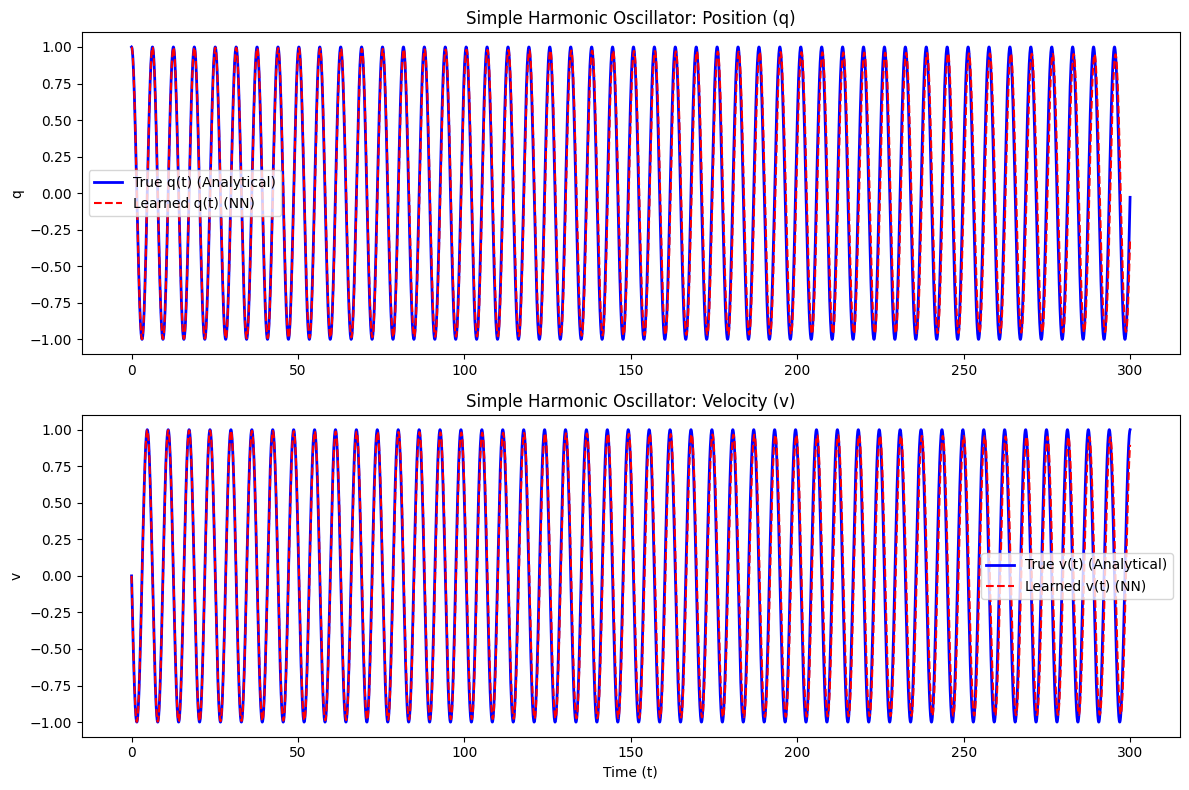

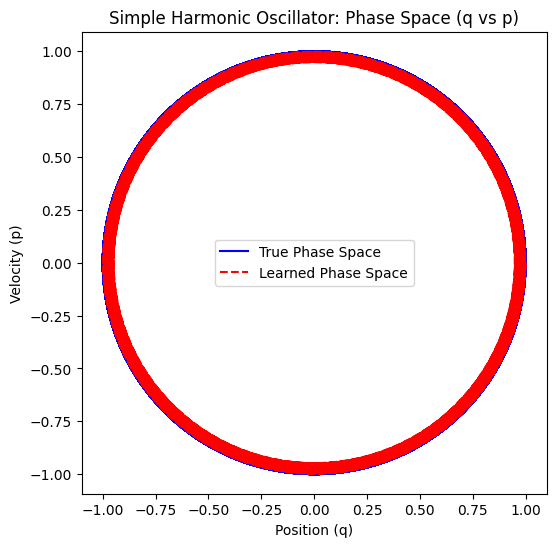

In [11]:
''' 
plot result
'''
t_true, q_true, v_true = lgr_states_true
p_true = ham_states_true[2]
t_learned, q_learned, v_learned = lgr_states_learned
p_learned = ham_states_learned[2]

H_transform_fn = ham.lagrangian_to_hamiltonian(L_analytical)
#L_transform_fn = ham.hamiltonian_to_lagrangian(H_analytical)

H_true = jax.vmap(H_analytical)(ham_states_true) 
H_from_LNN = jax.vmap(H_transform_fn)(ham_states_learned) #H

title_prefix="Simple Harmonic Oscillator:"
plotting.plot_trajectory_comparison(
    t_true, q_true, v_true, 
    t_learned, q_learned, v_learned,
    title_prefix
)

plotting.plot_phase_space(
    q_true, p_true, 
    q_learned, p_learned,
    title_prefix
    )

In [12]:
np.savez(
    "results_H1D_NN.npz", 
    t_learned=np.array(t_learned),
    q_learned=np.array(q_learned),
    v_learned=np.array(v_learned),
    p_learned=np.array(p_learned),
    t_true=np.array(t_true),
    q_true=np.array(q_true),
    v_true=np.array(v_true),
    p_true=np.array(p_true)
)